### Energy calibration

In [1]:
import sys
utils_path = '/global/homes/f/fnafis/nfkrstc/'
if utils_path not in sys.path:
    sys.path.append(utils_path)
import krstc_utils as kutils

import pygama.lgdo.lh5_store as lh5
from pygama.flow import DataGroup
import pygama.math.histogram as pgh
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('/global/homes/f/fnafis/utils_nf/nfuad.mpl')
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import h5py


runs = [76, 71, 66, 80] #86 is temp test, only keep 3734-3738(inclusive)
bias_voltages = [2200, 2300, 2400, 2500]

skip_cycless = [[],
               [3298,3299,3300,3301],
               [],
               []]
bkg_run = 85 #72
bkg_skip_cycles = None #np.arange(3315,3340)
    
big_peaks_keV = [239.6, 351.9, 583.2, 609.32, 911.2, 1120.3, 1460.8]


#@numba.njit
def gauss(x, A, mu, sigma):
    return A* np.exp(-(x-mu)**2 / (2*sigma**2))
#@numba.njit
def bkg(x, p0, p1, p2):
    return p0 + p1*x + p2*x**2

#@numba.njit
def dist(x,  A, mu, sigma, p0, p1, p2):  # bkg = p0 + p1*x + p2*x**2
    return gauss(x, A, mu, sigma) + bkg(x, p0, p1, p2)

## Load data

In [32]:
runs=[25]
df, run_types, run_descriptions = kutils.load_dsp(runs=runs, params=[['trapEmax']], verbose=False)
df

cal const:      Run   p0      p1   p2
25   25  0.0  0.4235  0.0


,trapEmax,trapEmax_cal_keV,run,cycle,runtime_s
0,234.483658,99.303833,25,2450,1704.956563
1,346.043457,146.549408,25,2450,1704.956563
2,3596.598877,1523.159668,25,2450,1704.956563
3,1676.562988,710.024414,25,2450,1704.956563
4,577.249512,244.465164,25,2450,1704.956563
...,...,...,...,...,...
85830,2672.440186,1131.778442,25,2459,1203.535507
85831,3444.901611,1458.915894,25,2459,1203.535507
85832,661.817078,280.279541,25,2459,1203.535507
85833,36852.949219,15607.223633,25,2459,1203.535507


# whole spectrum

Text(0.5, 0, 'trapEmax (ADC)')

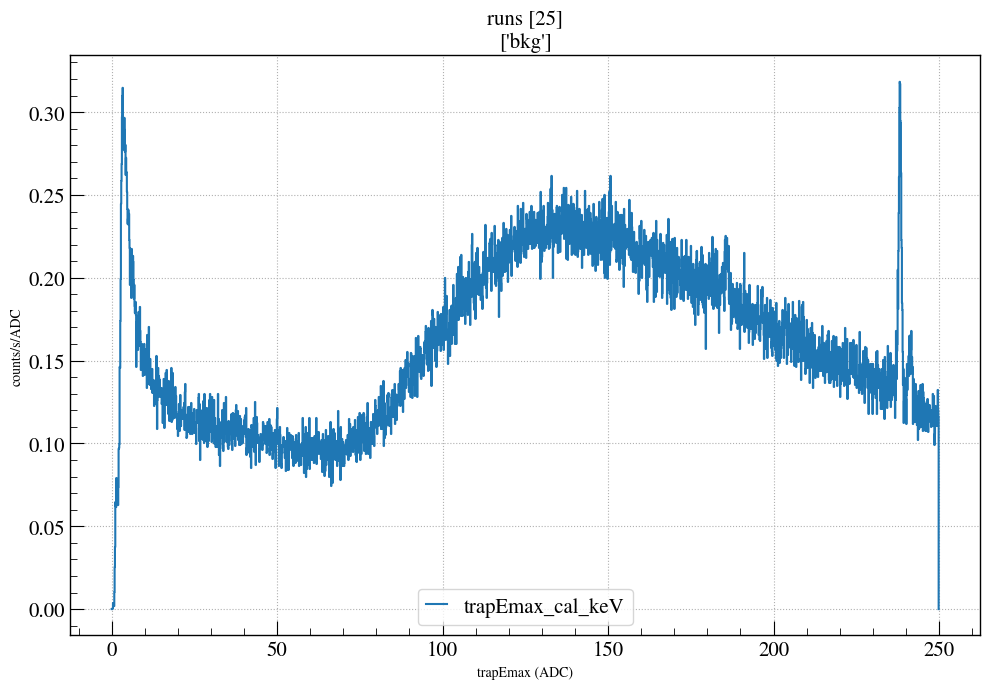

In [41]:
# plot whole spectrum
hist, bins, vars = kutils.get_1D_hist(df['trapEmax_cal_keV'], df['runtime_s'], range=(0, 250), binsize=0.1)
plt.title('runs '+str(runs)+'\n'+str(run_types))
plt.ylabel('counts/s/ADC')
plt.xlabel('trapEmax (ADC)')

# peak fitting

0.1 +/- inf
3390.0 +/- inf
1.0 +/- inf
-175.08255314280117 +/- inf
0.10154361922378073 +/- inf
-1.4721248250738829e-05 +/- inf


/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'counts/s/keV')

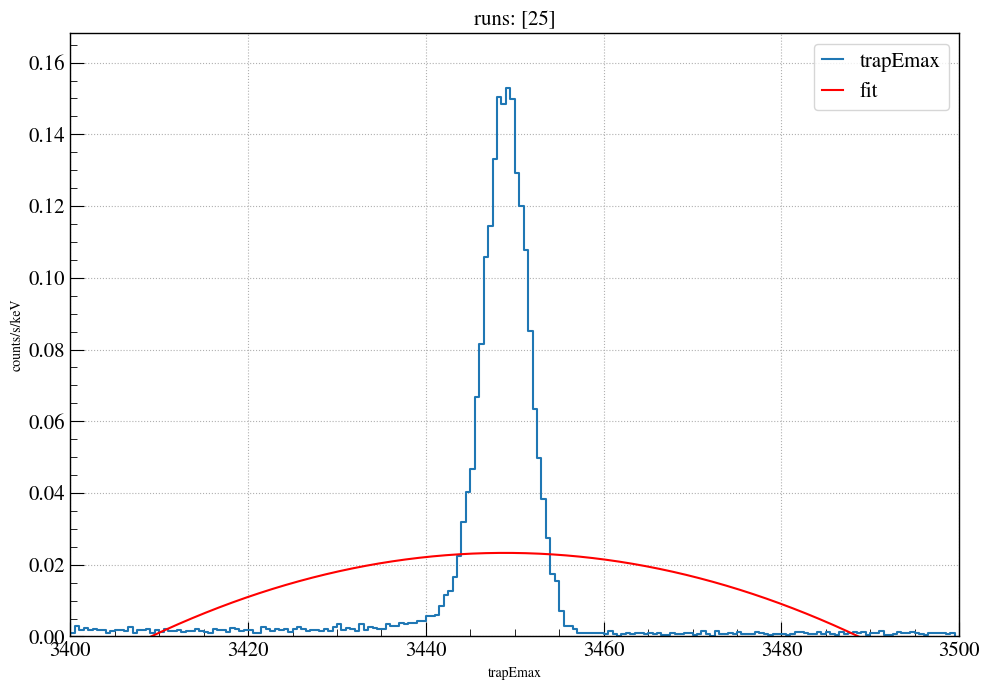

In [36]:
range = (3400,3500)
hist, bins, vars = kutils.get_1D_hist(df['trapEmax'], df.runtime_s, range=range, binsize=0.5)
#plt.title('run '+str(run)+ ', '+runtype + '\n' + description)
plt.title('runs: '+str(runs))


bins_mid = (bins[1:] + bins[:-1])/2
guess = [0.1, 3390, 1, 0, 0, 0]
popt, pcov = curve_fit(dist, bins_mid, hist, p0=guess)
errs = np.sqrt(np.diag(pcov))

x = np.linspace(*range, 1000)
plt.plot(x, dist(x, *popt), 'r-', label='fit')

for err,param in zip(errs,popt):
    print(param, '+/-', err)

plt.xlim(range)
plt.ylim(0, 1.1*max(hist))
plt.legend()
plt.ylabel('counts/s/keV')


# 238 peak

/opt/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1.0 +/- inf
225.0 +/- inf
1.0 +/- inf
-6.603287892555487 +/- inf
0.005054934243758434 +/- inf
-9.668142911999477e-07 +/- inf


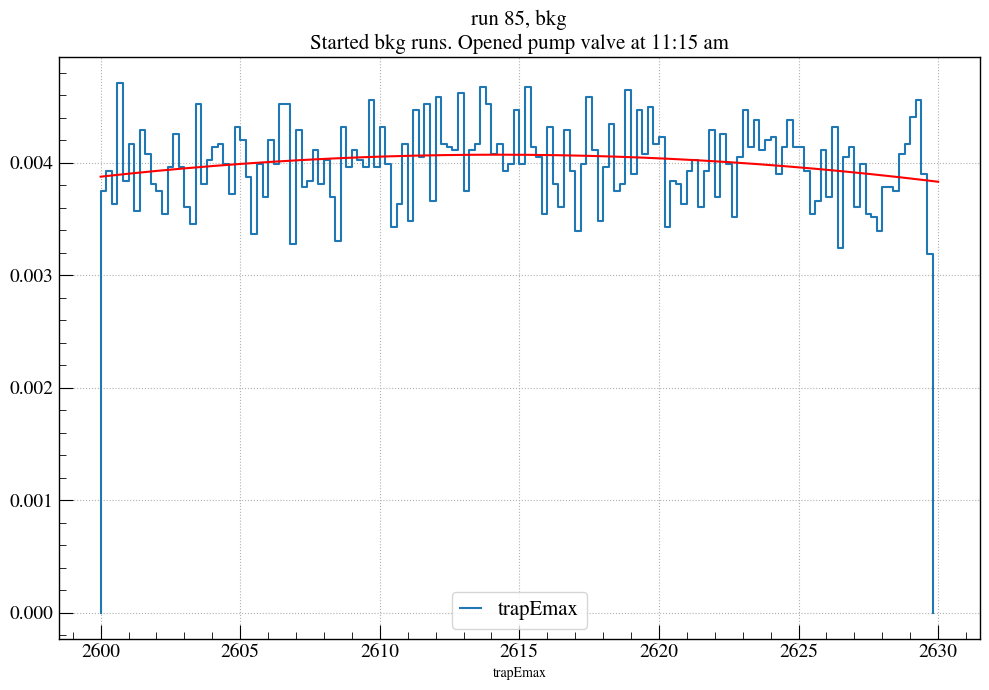

In [18]:
peak_search_range = [2600,2630]
hist, bins, vars = kutils.get_1D_hist(df['trapEmax'], df.runtime_s, range=peak_search_range, binsize=0.2)
plt.title('run '+str(run)+ ', '+runtype + '\n' + description)




bins_mid = (bins[1:] + bins[:-1])/2
guess = [1, 225, 1, 0, 0, 0]
popt, pcov = curve_fit(dist, bins_mid, hist, p0=guess)
errs = np.sqrt(np.diag(pcov))

x = np.linspace(*peak_search_range, 1000)
plt.plot(x, dist(x, *popt), 'r-', label='fit')

for err,param in zip(errs,popt):
    print(param, '+/-', err)

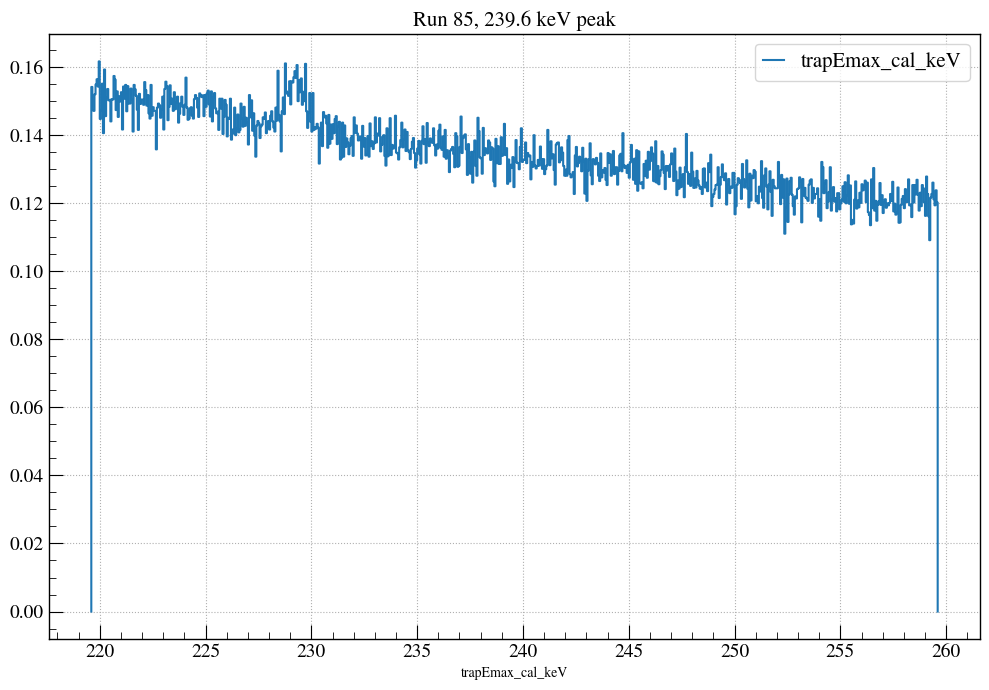

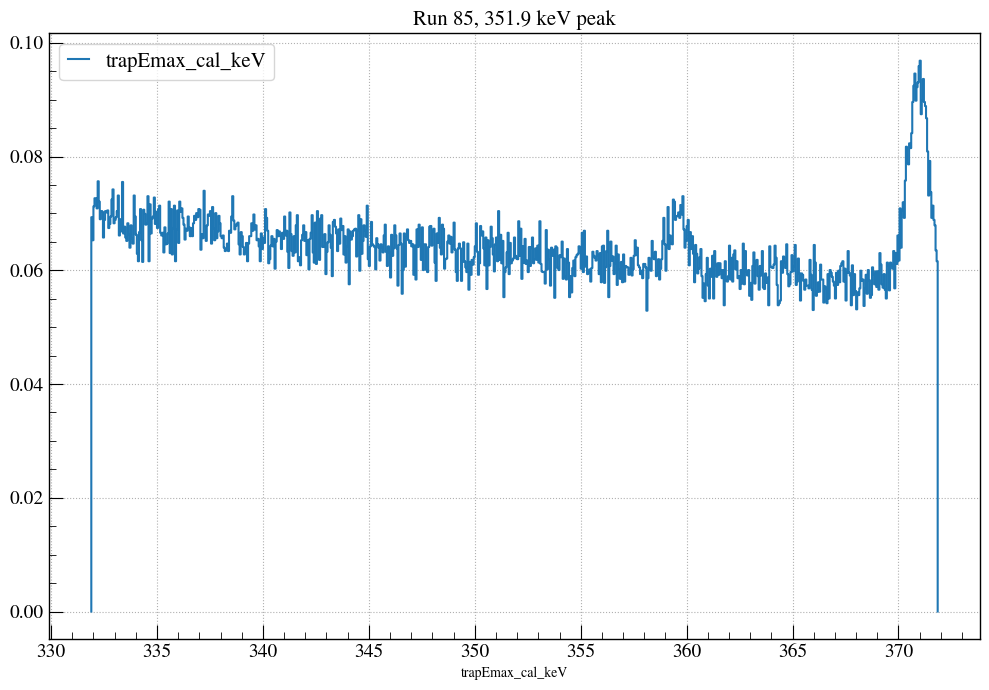

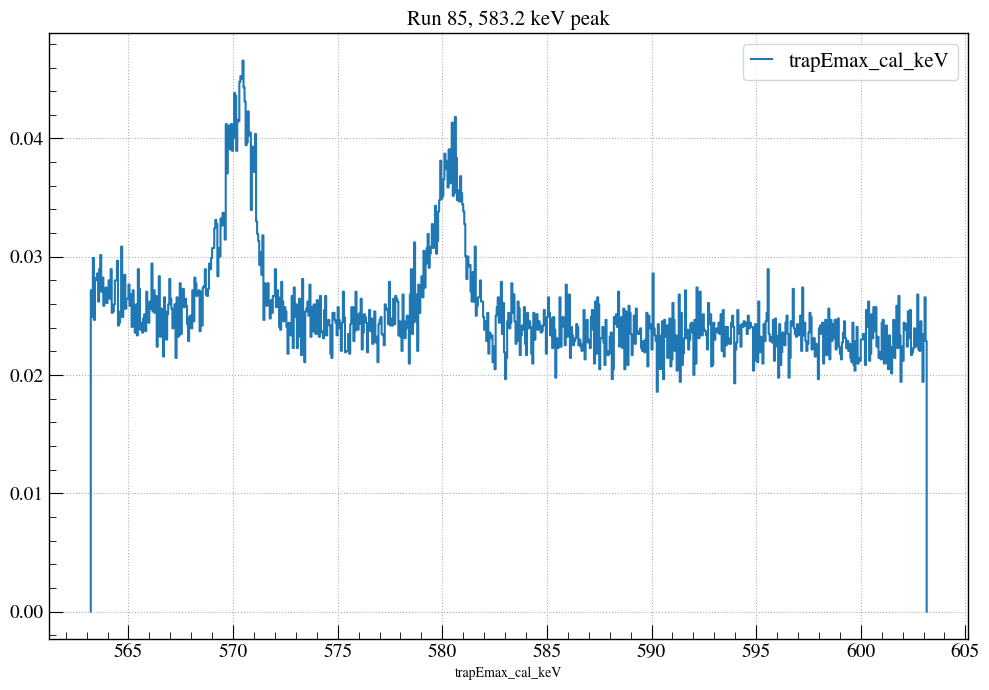

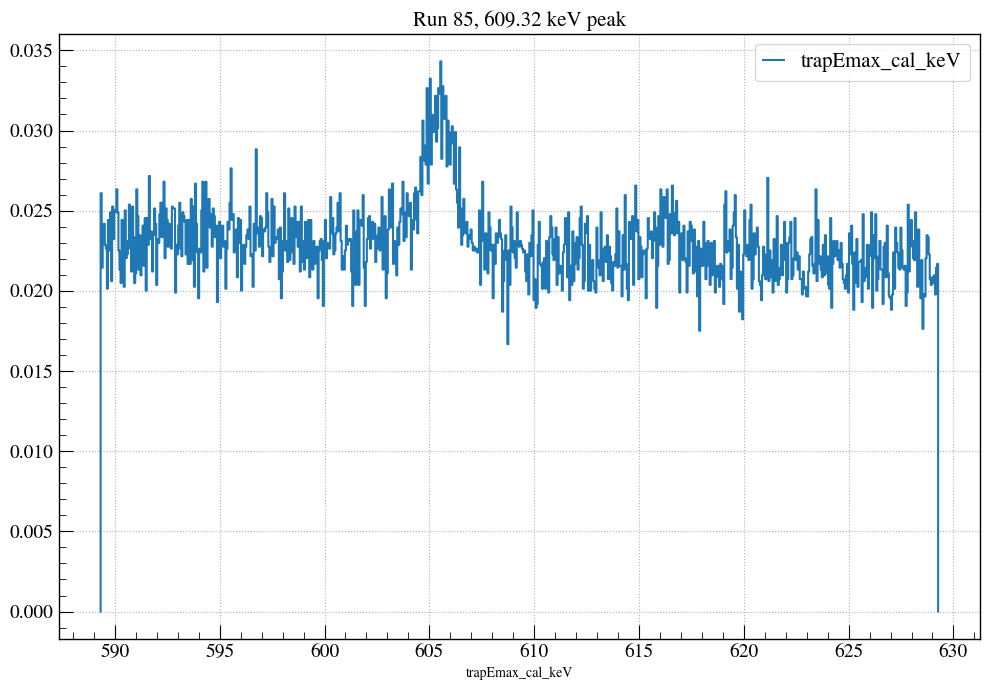

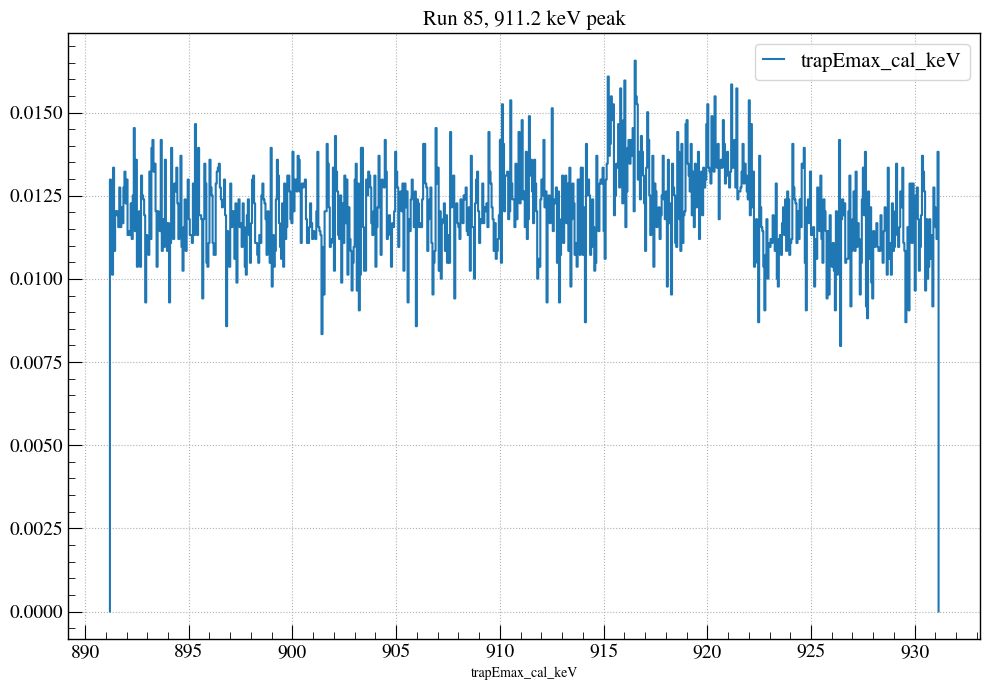

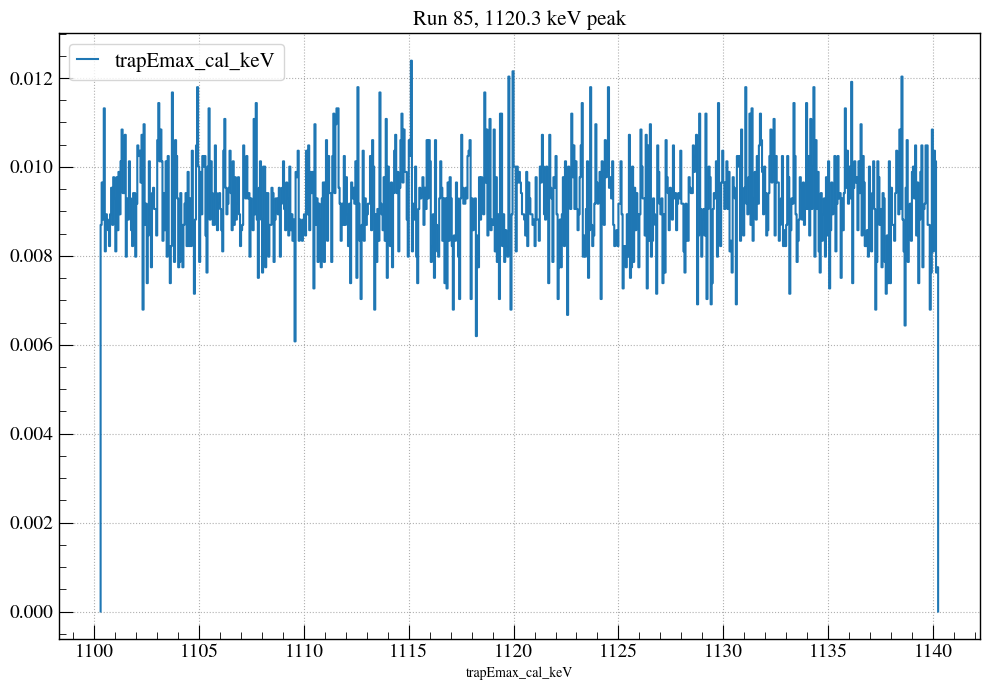

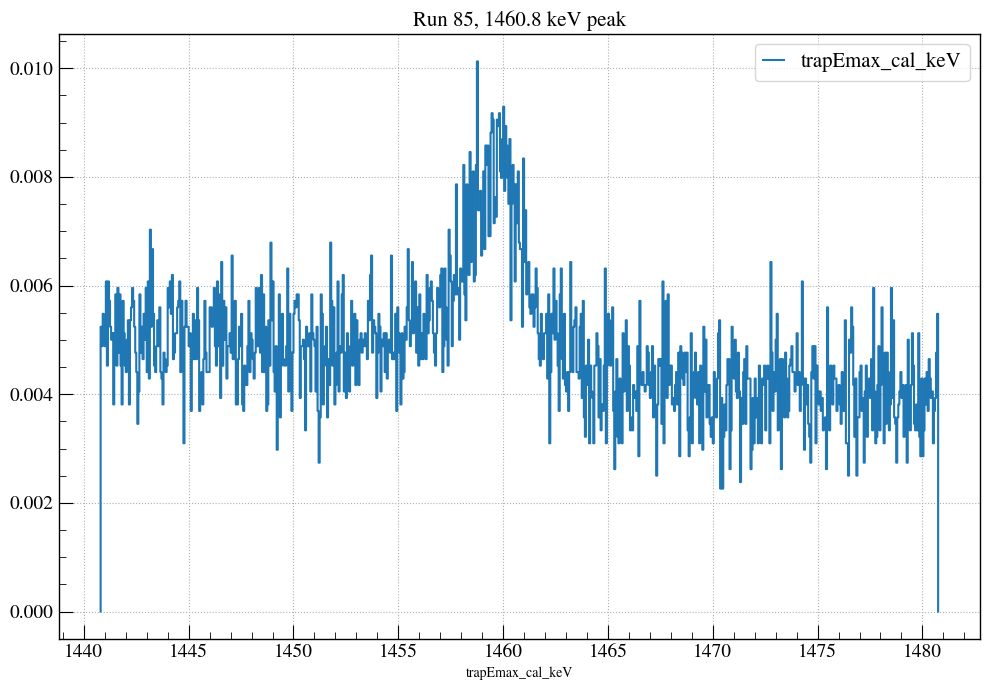

In [17]:
for big_peak in big_peaks_keV:
    plt.figure()
    a = kutils.get_1D_hist(df['trapEmax_cal_keV'], df.runtime_s, range=(big_peak-20, big_peak+20), binsize=0.05)
    plt.title(f'Run {run}, {big_peak} keV peak')
    plt.xlabel('trapEmax_cal_keV')

(array([3.69307189e-04, 1.45935905e-03, 7.96393084e-03, ...,
        2.97828378e-05, 4.76525405e-05, 1.19131351e-05]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 6.974e+03, 6.975e+03,
        6.976e+03]),
 array([  62,  245, 1337, ...,    5,    8,    2]))

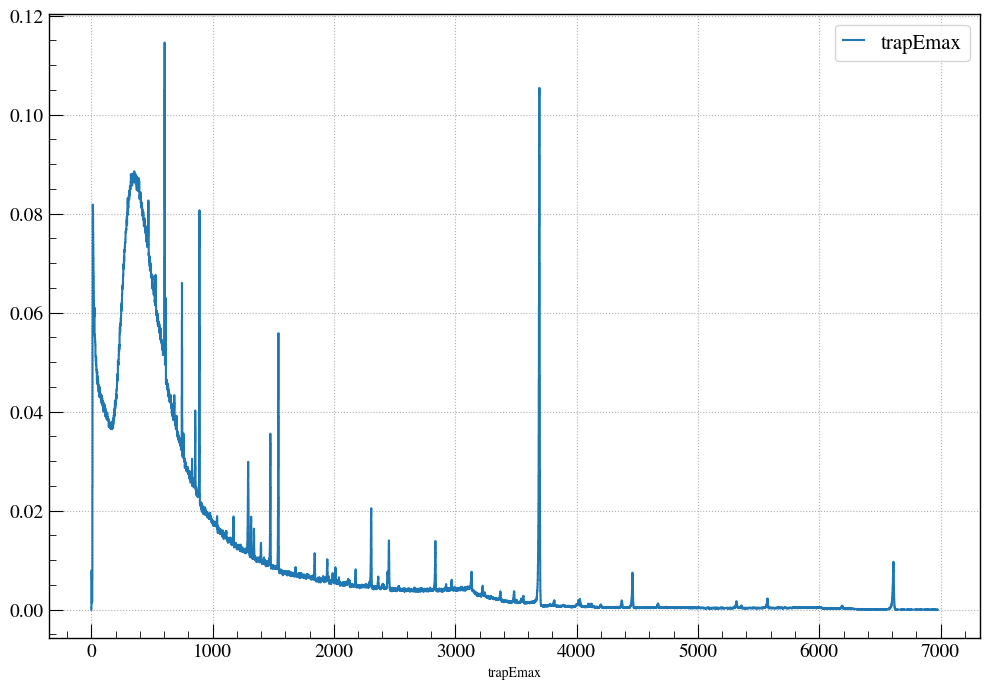

In [26]:
kutils.get_1D_hist(df['trapEmax'], df.runtime_s, range=(0,3000/0.43), binsize=1)

In [2]:
cycles=[2028,2038]
dg = DataGroup(datagroup, load=True)
# get file list and load energy data (numpy array)
# lh5_dir = os.path.expandvars(dg.config['lh5_dir'])
lh5_dir = dg.lh5_dir
dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']


dsp_list = dsp_list[cycles[0]-CYCLE_0:cycles[1]-CYCLE_0]

#edata = lh5.load_nda(dsp_list, ['trapEmax'], 'ORSIS3302DecoderForEnergy/dsp')
edata = lh5.load_nda(dsp_list, [etype], channel )


energy_uncalibrated = edata[etype] #energy_uncalibrated

print(dsp_list)
energy_uncalibrated.shape

9     /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
10    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
11    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
12    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
13    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
14    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
15    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
16    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
17    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
18    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
dtype: object


(1097623,)

## Known peaks

In [3]:
#big_peaks_keV = [609.320, 1460.8, 1764.5, 2614.5]
#big_peaks_keV = [239.6, 295.2, 351.9, 583.2, 609.32, 911.2, 1120.3, 1460.8, 1764.5]
big_peaks_keV = [239.6, 351.9, 583.2, 609.32, 911.2, 1120.3, 1460.8]
#print('Total known peaks used: ',len(big_peaks_keV))
peak_list = pd.read_csv('peak_list.txt', delimiter=' ')
peak_list_tall = peak_list[peak_list.iloc[:,2]=='T']
print(peak_list_tall)
#T=Tall means yes you might be able to calibrate with this

      iso    e_kev tall
0   212Pb   239.60    T
1   214Pb   295.20    T
3   214Pb   351.90    T
4   208Tl   510.80    T
5   208Tl   583.20    T
6   214Bi   609.30    T
10  228Ac   911.20    T
11  228Ac   968.97    T
12  214Bi  1120.30    T
16    40K  1460.80    T
22  214Bi  1764.50    T
27  208Tl  2614.50    T


## Hist of uncalibrated energy

ADC/bin:  0.267
keV/bin:  0.120


Text(0.5, 0, 'Max of waveforms calculated from trapezoidal filter (ADC), bin_size=2ADC')

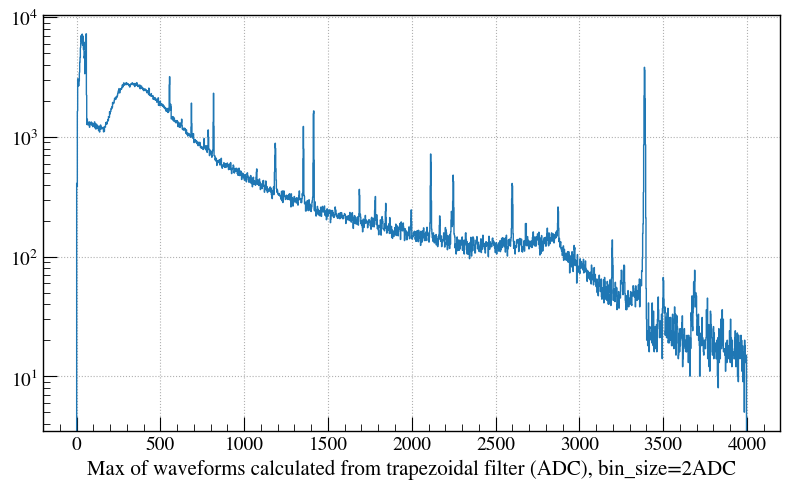

In [12]:
n_bins = 15000
bin_size = 2 #ADC
adc_range = (0,4000)
adc_per_bin = (adc_range[1]-adc_range[0])/n_bins
keV_per_bin = adc_per_bin*0.45
print('ADC/bin: ', "{:.3f}".format(adc_per_bin))
print('keV/bin: ', "{:.3f}".format(keV_per_bin))

hist, bins, var = pgh.get_hist(energy_uncalibrated, dx=bin_size,
                               range=adc_range)
hist = hist[1:]
bins = bins[1:]
var = var[1:]

regular_hist, regular_bins = np.histogram(energy_uncalibrated, 
                                          bins=n_bins, 
                                          range=adc_range)
#bin_centers = np.histogram_bin_edges(energy_uncalibrated, bins=n_bins,
#                                     range=adc_range)

regular_bins = regular_bins[:-1]
#pgh.plot_hist(hist, bins)
n = plt.hist(energy_uncalibrated, bins=np.arange(*adc_range,bin_size), histtype='step')
#convert to log scale
plt.yscale('log')
plt.xlabel('Max of waveforms calculated from trapezoidal filter (ADC), bin_size='+str(bin_size)+'ADC')
#plt.xlim(500,600)

Text(0.5, 0, 'Calibrated energy spectrum (KrSTC, background run), bin_size=1 keV')

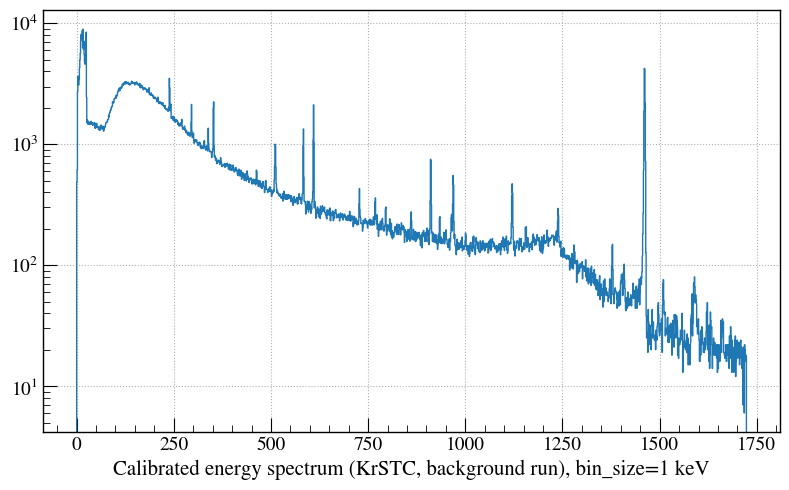

In [19]:
# convert ADC to keV using linear fit of 0.431*x+0.132
calibration_consts = [0.431, 0.132]
bin_size_kev = 1
keV_range = (0,np.polyval(calibration_consts,adc_range[1]))
ecal_keV = np.polyval(calibration_consts,energy_uncalibrated)
m = plt.hist(ecal_keV, bins=np.arange(*np.polyval(calibration_consts,adc_range), bin_size_kev), histtype='step')
#convert to log scale
plt.yscale('log')
plt.xlabel('Calibrated energy spectrum (KrSTC, background run), bin_size='+str(bin_size_kev)+' keV')

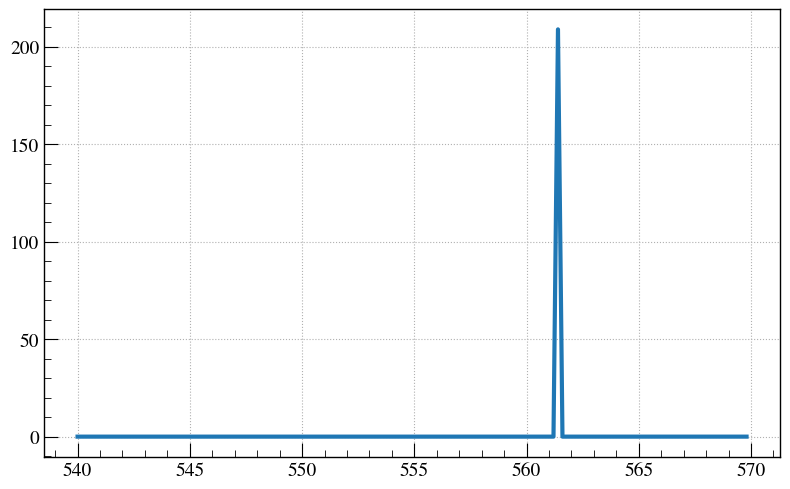

In [7]:
params = curve_fit(pgf.gauss_norm, x, y, p0=[550, 15])
yy = pgf.gauss_norm(x, *params[0])
plt.plot(x, yy, label='fit')

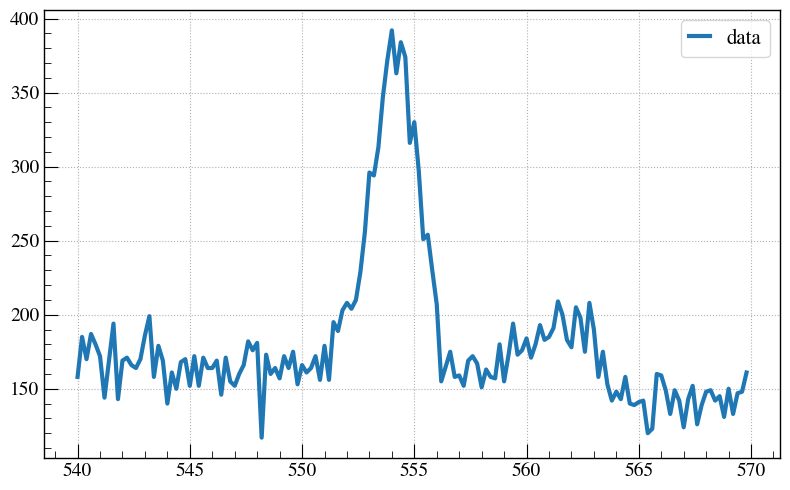

In [6]:
x = n[1][2700:2850]
y = n[0][2700:2850]
plt.plot(x,y, label='data')

plt.legend()

## Locating extremas of uncalibrated energy

In [ ]:
pgh_formatted = True
markers = True
log_scale = True
show_stats = True
errorbar = False

peak_detection_n_sigma = 4.0
n_sigma_for_view = peak_detection_n_sigma


imaxes, imins = cb.get_i_local_extrema(hist/np.sqrt(var), n_sigma_for_view)
#pgc doesn't have this function!
#print('imaxes:', imaxes)

#print(hist)
bin_centers = pgh.get_bin_centers(bins)
#print(bin_centers)

#print('max bin centers:', bin_centers[imaxes])
#print('bin vars:', var[imaxes])
#print('max bin values:', hist(imaxes))



linewidth = 1
if errorbar:
    pgh.plot_hist(hist, bins,var, lw=linewidth) 
else:
    pgh.plot_hist(hist,bins, lw=linewidth)
#plt.ylim(0.1,1.1*np.amax(hist))
if markers:
    plt.plot(bin_centers[imaxes], hist[imaxes], lw=0, marker='v')
    #plt.plot(bin_centers[imins], hist[imins], lw=0, marker='^')
if log_scale: plt.yscale('log')

#plot known peak lines from CW
#-------------------------------------------------------------
tall_peaks = True
current_pars=[0.44952624,0.23851961]
current_inv_pars=[1/current_pars[0], current_pars[1]*(-1)/current_pars[1]]
colors = ['b','g','r','c','y','m','k','maroon','dodgerblue','darkgoldenrod', 'gold',
         'darkslategray', 'orange']
color_index=0
peak_list_to_plot = peak_list
if tall_peaks: peak_list_to_plot = peak_list_tall
for i in range(peak_list_to_plot.shape[0]):
    plt.axvline(x=np.polyval(current_inv_pars,peak_list_to_plot.iloc[i,1]), 
                label=peak_list.iloc[i,0]+'='+
                str(f'{np.polyval(current_inv_pars,peak_list_to_plot.iloc[i,1]):.1f}'), 
                color=colors[color_index], ls='--', lw=1)
    color_index+=1
plt.legend()
#------------------------------------------------------
#plt.xlim(3200,3300)
plt.title('Location of extremas on hist of energy_uncalibrated (log scale)', fontsize=title_fontsize)

tup = {'max bins':imaxes,
       'bin centers':bin_centers[imaxes],
       'value':hist[imaxes],
       'uncertainty':np.sqrt(var[imaxes]),
       'bin centers calibrated:':np.polyval(current_pars, bin_centers[imaxes])}
pd.DataFrame(tup)
plt.xlim(0,150)

NameError: name 'cb' is not defined

## Zoom in

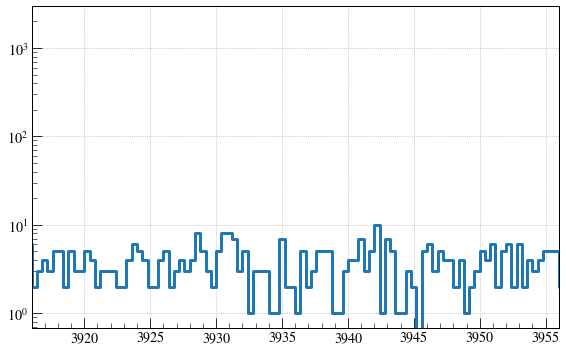

In [ ]:
def zoom_in_around(val, tolerance = 20):
    if pgh_formatted:
        if errorbar:
            pgh.plot_hist(hist, bins,var) 
        else:
            pgh.plot_hist(hist,bins)
            #plt.ylim(0.1,1.1*np.amax(hist))
    else: plt.hist(energy_uncalibrated, bins=n_bins)
    if markers: plt.plot(bin_centers[imaxes], hist[imaxes], lw=0, marker='v')
    if log_scale: plt.yscale('log')

    plt.xlim(val-tolerance,val+tolerance)
    #plt.title('Location of extremas on hist of energy_uncalibrated (log scale)', fontsize=title_fontsize)

zoom_in_around(3936)

## Finding peaks of uncalibrated energy

In [ ]:
found_peaks, pars = cb.hpge_find_E_peaks(hist, bins, var, big_peaks_keV, 
                                         deg=0, 
                                         n_sigma=peak_detection_n_sigma)
#deg must be <len(big_peaks_keV)-1
#found_peaks = found_peaks[1:]
print(big_peaks_keV)
print('Peaks found:',found_peaks)
print('pars',pars)
uncal2keV = 1/pars[0]

#diff = found_peaks - big_peaks_keV
#plt.plot(diff)

[239.6, 351.9, 583.2, 609.32, 911.2, 1120.3, 1460.8]
Peaks found: [ 554.2     817.     1352.6001 1413.8    2113.8    2599.     3389.4   ]
pars [0.4310382 0.       ]


In [ ]:
found_peaks

array([ 554.2   ,  817.    , 1352.6001, 1413.8   , 2113.8   , 2599.    ,
       3389.4   ], dtype=float32)

## Fit gaussian to the top of peaks

In [ ]:
def fit_gaussian_once(hist,bins,var, pt_pars, n_to_fit=7):
    mu1s = pt_pars[:,0]#Extracting the mu of each peaks after first gaussian fit

    #Gaussian fitting again with mu1s instead of just found peaks i.e. using better guesses
    #n_to_fit=8
    pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(hist, bins, var, mu1s, n_to_fit=n_to_fit, 
                                               inflate_errors=True, gof_method='Pearson')

    #mus = pt_pars[:,0]
    #mu_vars = pt_covs[:,0,0]
    #print('peak top fits 2:', mus, mu_vars)
    #print(pt_pars[0])
    return pt_pars, pt_covs

In [ ]:
big_peaks_keV

[239.6, 351.9, 583.2, 609.32, 911.2, 1120.3, 1460.8]

In [ ]:
def matched_peaks(bin_centers, imaxes, known_peaks, tol=5):
    matched_peaks = []
    for peak in known_peaks:
        for imax in imaxes:
            if bin_centers[imax]<peak+tol and bin_centers[imax]>peak-tol:
                matched_peaks.append(bin_centers[imax])
                print(imax)
                break
    return matched_peaks
big_peaks_keV_adc = [item/current_pars[0] for item in big_peaks_keV]
#found_peaks = matched_peaks(bin_centers, imaxes, big_peaks_keV_adc)
print(found_peaks)

[ 554.2     817.     1352.6001 1413.8    2113.8    2599.     3389.4   ]


[ 554.2     817.     1352.6001 1413.8    2113.8    2599.     3389.4   ]
[False, False, False, False, False, False, False]
[ 554.2     817.     1352.6001 1413.8    2113.8    2599.     3389.4   ]
<class 'int'>
[[5.54226445e+02 1.74835529e+00 8.04725299e+02]
 [8.16870911e+02 1.61277199e+00 5.45927937e+02]
 [1.35334216e+03 2.04378608e+00 2.77995232e+02]
 [1.41411283e+03 1.86905004e+00 4.28392952e+02]
 [2.11373374e+03 1.98830967e+00 1.75777082e+02]
 [2.59933986e+03 2.69493571e+00 9.41667715e+01]
 [3.38973807e+03 2.60622620e+00 9.02327025e+02]]
[[5.54226445e+02 1.74835515e+00 8.04725323e+02]
 [8.16870911e+02 1.61277172e+00 5.45927976e+02]
 [1.35321553e+03 1.80373580e+00 2.81764895e+02]
 [1.41408307e+03 1.72591622e+00 4.35371682e+02]
 [2.11373374e+03 1.98831200e+00 1.75777022e+02]
 [2.59980302e+03 3.16391637e+00 9.49278637e+01]
 [3.38976215e+03 2.90020365e+00 8.92869353e+02]]
[False, False, False, False, False, False, False]


<ipython-input-12-7fcc9912457d>:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,25*pt_pars[i,2])


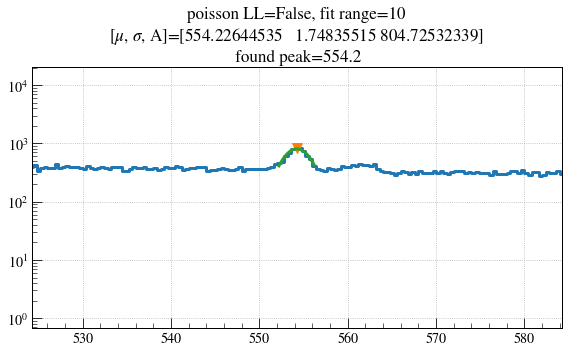

<ipython-input-12-7fcc9912457d>:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,25*pt_pars[i,2])


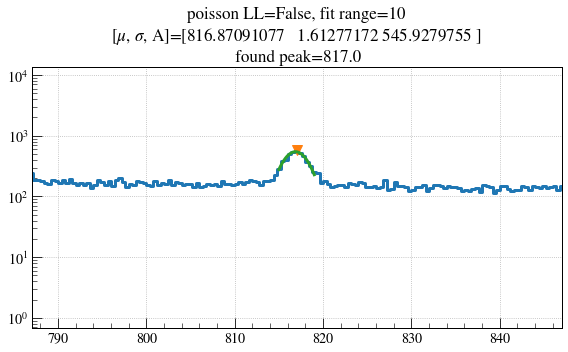

<ipython-input-12-7fcc9912457d>:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,25*pt_pars[i,2])


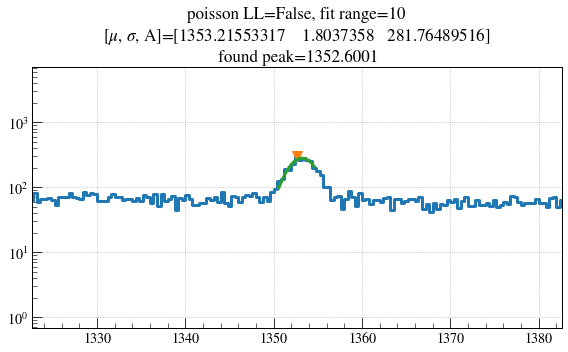

<ipython-input-12-7fcc9912457d>:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,25*pt_pars[i,2])


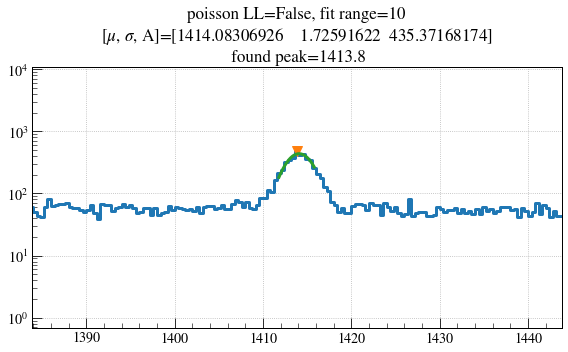

<ipython-input-12-7fcc9912457d>:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,25*pt_pars[i,2])


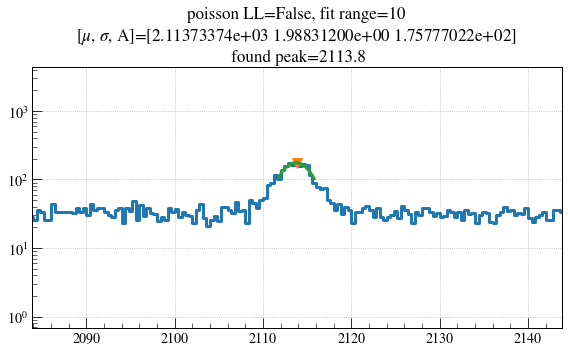

<ipython-input-12-7fcc9912457d>:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,25*pt_pars[i,2])


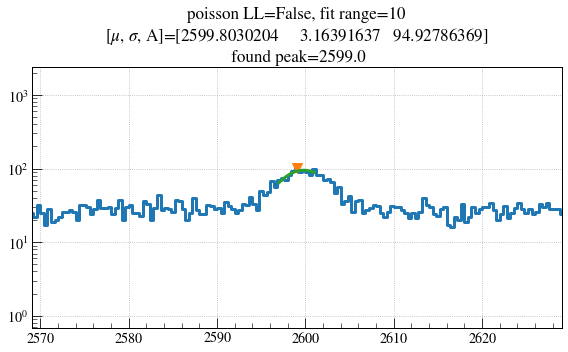

<ipython-input-12-7fcc9912457d>:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,25*pt_pars[i,2])


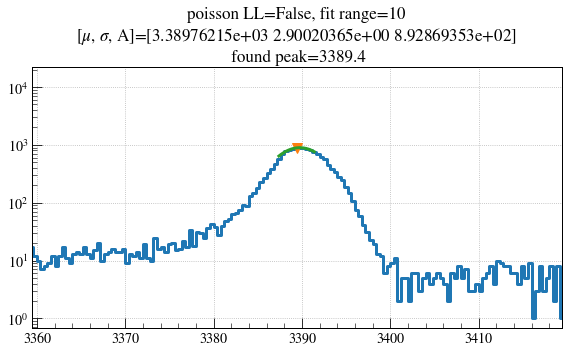

In [ ]:
#E_peaks = [hist[pgh.find_bin(Euci, bins)] for Euci in found_peaks] 
#print(E_peaks)
print(found_peaks)
n_to_fit=10
'''
pt_pars: a list of best-fit parameters (mode=mu, sigma, max=amplitude) for 
each peak-top fit pt_covs: a list of covariance matrices for each pars
'''

poissonLL = []
for i in range(len(found_peaks)): poissonLL.append(False)
#Automatic fitting option selection for peaks
'''
poissonLL_threshold = 5 #events
for E_peak in found_peaks:
    peak_loc = np.where(bin_centers==E_peak)[0][0]
    poissonLL.append(np.any(hist[peak_loc-n_to_fit:peak_loc+n_to_fit]<
                            poissonLL_threshold))
#Manually fitting option selection for peaks
#poissonLL = [False, False, False, False, False]
'''

print(poissonLL)
print(found_peaks)
print(type(n_to_fit))
pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(hist, bins, var, found_peaks, poissonLL,
                                           n_to_fit=n_to_fit)
print(pt_pars)
mu1s = pt_pars[:,0]
pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(hist, bins, var, mu1s, poissonLL,
                                           n_to_fit=n_to_fit)
#pt_pars, pt_covs = fit_gaussian_once(hist, bins, var, pt_pars,
 #                                    n_to_fit=n_to_fit)
print(pt_pars)
mus_final = pt_pars[:,0]
sigmas_final = pt_pars[:,1]
print(poissonLL)

def plot_gaussian_at_peak(i):
    peak = found_peaks[i]
    zoom_in_around(peak, tolerance=30)
    plt.ylim(0,25*pt_pars[i,2])
    pgu.plot_func(pgf.gauss_basic, pt_pars[i],
                 range=(peak-0.5*n_to_fit*adc_per_bin,peak+0.5*n_to_fit*adc_per_bin))
    plt.title('poisson LL='+str(poissonLL[2])+', fit range='+str(n_to_fit) +
              '\n[$\mu$, $\sigma$, A]='+str(pt_pars[i])+'\n found peak='+str(found_peaks[i]))
    plt.show()
    

#plot_gaussian_at_peak(0)
for i in range(len(mu1s)):
    plot_gaussian_at_peak(i)
#print(pt_covs)

## Finding fitting pars using y=$\mu$ of gaussian fitting and x=known peaks

In [ ]:
#big_peaks_keV = big_peaks_keV[0:len(mus)]
n_deg = 1
#big_peaks_keV = [609.320, 1460.8, 2614.5]
#big_peaks_keV = [239.6, 295.2, 351.9, 583.2, 609.32, 911.2, 1120.3,  1460.8, 1764.5]
mus = pt_pars[:,0]
mu_vars = pt_covs[:,0,0]
print(mus)
pars, cov = cb.hpge_fit_E_scale(mus, mu_vars, big_peaks_keV, deg=n_deg)
print('pars:', pars)
#print('cov:', cov)


[ 554.22644535  816.87091077 1353.21553317 1414.08306926 2113.7337411
 2599.8030204  3389.76214971]
pars: [ 2.32083406 -0.48210094]


## inversion of previous cell (i.e. x=$\mu$, y=known peaks)

In [ ]:
#same thing as before. just using x=mus and y=big_peaks_keV
pars, covs = cb.hpge_fit_E_cal_func(mus, mu_vars, big_peaks_keV, pars, deg=n_deg)
print('pars: ', pars)
#print('covs: ', inv_covs)

pars:  [0.43087949 0.20792761]


## Calibration of energies (trapEmax) based on the pars

pars:  [0.43087949 0.20792761]
   Known peaks(keV)  Uncalibrated peaks(ADC)  Calibrated peaks(keV)  \
0            239.60               554.200012             239.001358   
1            351.90               817.000000             352.236481   
2            583.20              1352.600098             583.015625   
3            609.32              1413.800049             609.385437   
4            911.20              2113.800049             911.001038   
5           1120.30              2599.000000            1120.063721   
6           1460.80              3389.399902            1460.630859   

   Error(keV)  
0   -0.598642  
1    0.336481  
2   -0.184375  
3    0.065437  
4   -0.198962  
5   -0.236279  
6   -0.169141  


(1400.0, 1600.0)

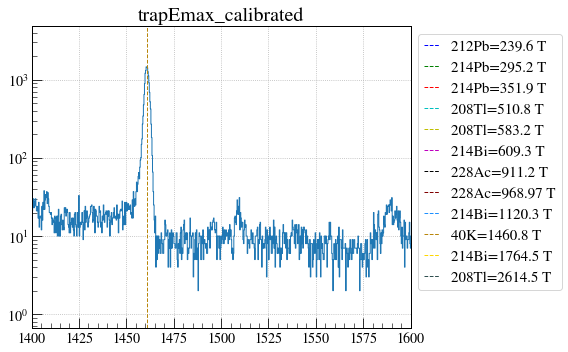

In [ ]:
found_peaks = found_peaks[0:len(mus)]
calibrated_peaks = np.polyval(pars, found_peaks)
#print(type(pars))
print('pars: ', pars)
#print('Uncalibrated peaks: ', found_peaks)
#print('Given peaks: ', big_peaks_keV)
#print('Calibrated peaks: ', calibrated_peaks)


energy_calibrated = np.polyval(pars, energy_uncalibrated)
hist_calibrated, bins_calibrated, var_calibrated = pgh.get_hist(energy_calibrated, bins=n_bins)



imaxes_calibrated, imins = cb.get_i_local_extrema(np.sqrt(hist_calibrated), peak_detection_n_sigma)
#pgc doesn't have this function!
#print(imaxes_calibrated, imins)
bin_centers_calibrated = pgh.get_bin_centers(bins_calibrated)
#print(bin_centers)

pgh.plot_hist(hist_calibrated, bins_calibrated, lw=1)

#plot known peak lines from CW
#-------------------------------------------------------------
tall_peaks = True
#current_pars=[0.44952624,0.23851961]
#current_inv_pars=[1/current_pars[0], current_pars[1]*(-1)/current_pars[1]]
color_index=0
peak_list_to_plot = peak_list
if tall_peaks: peak_list_to_plot = peak_list_tall
for i in range(peak_list_to_plot.shape[0]):
    is_tall_label=''
    if peak_list_to_plot.iloc[i,2]=='T': is_tall_label=' T'
    label = peak_list_to_plot.iloc[i,0]+'='+str(peak_list_to_plot.iloc[i,1])+is_tall_label

    plt.axvline(x=peak_list_to_plot.iloc[i,1], 
                label=label,
                color=colors[color_index%12], ls='--', lw=1)
    color_index+=1
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
#------------------------------------------------------
plt.yscale('log')
plt.title('trapEmax_calibrated', fontsize=title_fontsize)

error = calibrated_peaks-big_peaks_keV
result_tup = {'Known peaks(keV)':big_peaks_keV,
       'Uncalibrated peaks(ADC)':found_peaks,
       'Calibrated peaks(keV)':calibrated_peaks,
       'Error(keV)':error}
print(pd.DataFrame(result_tup))
plt.plot()
plt.xlim(1400,1600)


array([ 239.01273558,  352.18084882,  583.28074604,  609.50731893,
        910.97244341, 1120.40972645, 1460.786913  ])

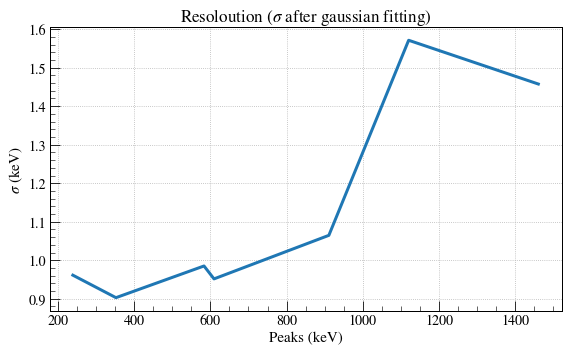

In [ ]:
mus_final_calibrated = np.polyval(pars, mus_final)
sigmas_final_calibrated = np.polyval(pars, sigmas_final)
plt.plot(mus_final_calibrated, sigmas_final_calibrated)
plt.title('Resoloution ($\sigma$ after gaussian fitting)')
plt.xlabel('Peaks (keV)')
plt.ylabel('$\sigma$ (keV)')
mus_final_calibrated

## Export calibrated energy histogram info

In [ ]:
import pickle as pk
file_to_write = open('trapEmax_calibrated.pk','wb')
#calibrated_energy_tuple = (hist_calibrated, bins_calibrated, var_calibrated)
pk.dump(energy_calibrated, file_to_write)
file_to_write.close()

(200.0, 400.0)

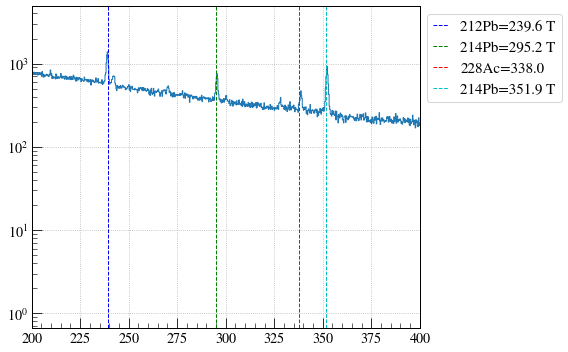

In [ ]:
pgh.plot_hist(hist_calibrated, bins_calibrated, lw=1)

x_min = 200
x_max = 400

#plot known peak lines from CW
#-------------------------------------------------------------
tall_peaks = False
color_index=0
peak_list_to_plot = peak_list
if tall_peaks: peak_list_to_plot = peak_list_tall
color_index=0
for i in range(peak_list_to_plot.shape[0]):
    label = ''
    if peak_list_to_plot.iloc[i,1]<x_max and peak_list_to_plot.iloc[i,1]>x_min:
        is_tall_label=''
        if peak_list_to_plot.iloc[i,2]=='T': is_tall_label=' T'
        label = peak_list_to_plot.iloc[i,0]+'='+str(peak_list_to_plot.iloc[i,1])+is_tall_label
    plt.axvline(x=peak_list_to_plot.iloc[i,1], label=label, 
                    color=colors[color_index%12], ls='--', lw=1)
    color_index+=1
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
#------------------------------------------------------
plt.yscale('log')
#plt.title('TrapEmax (calibrated using y='+str(current_pars[0])+'x+'+
          #str(current_pars[1])+')', fontsize=title_fontsize)

peak = 239.0
threshold = 10
#plt.xlim(peak-threshold,peak+threshold)
plt.xlim(x_min,x_max)

Text(0.5, 1.0, 'Hist energy_calibrated, peak=352')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


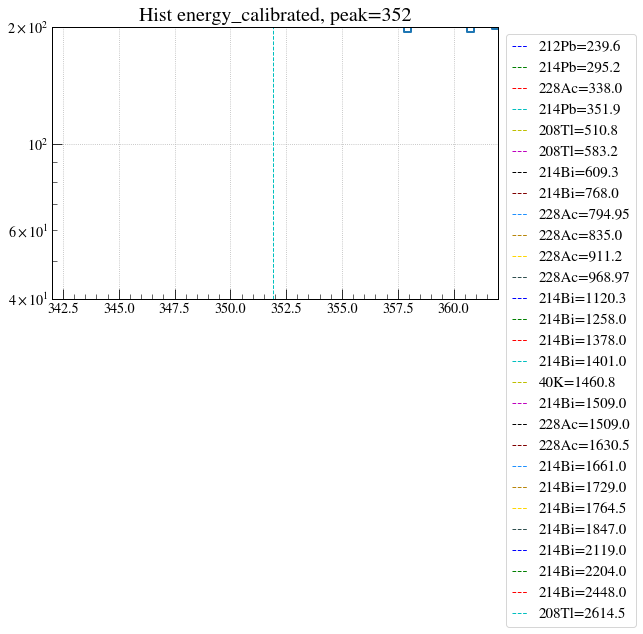

In [ ]:
pgh.plot_hist(hist_calibrated, bins_calibrated, lw=2)

#plot known peak lines from CW
#-------------------------------------------------------------
tall_peaks = False
color_index=0
peak_list_to_plot = peak_list
if tall_peaks: peak_list_to_plot = peak_list_tall
color_index=0
for i in range(peak_list_to_plot.shape[0]):
    plt.axvline(x=peak_list_to_plot.iloc[i,1], label=peak_list_to_plot.iloc[i,0]+
                    '='+str(peak_list_to_plot.iloc[i,1]), 
                    color=colors[color_index%12], ls='--', lw=1)
    color_index+=1
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
#------------------------------------------------------
plt.yscale('log')

peak_i = 0
threshold = 10
#plt.xlim(peak-threshold,peak+threshold)
#peak_val = peak_list_to_plot.iloc[peak_i,1]
peak_val=352
plt.xlim(peak_val-threshold, peak_val+threshold)
plt.ylim(40,200)
plt.title('Hist energy_calibrated, peak='+str(peak_val), fontsize=title_fontsize)

## Plotting residual

[ 239.01273558  352.18084882  583.28074604  609.50731893  910.97244341
 1120.40972645 1460.786913  ]
[-0.58726442  0.28084882  0.08074604  0.18731893 -0.22755659  0.10972645
 -0.013087  ]
[0.06037982 0.04433447 0.08677755 0.06188423 0.09867022 0.42565139
 0.02647515]
[239.6, 351.9, 583.2, 609.32, 911.2, 1120.3, 1460.8]
pars:  [0.43087949 0.20792761]
covs:  [[ 7.56395745e-09 -1.72486422e-05]
 [-1.72486422e-05  5.04242037e-02]]


,Known peaks(keV),Uncalibrated peaks(ADC),Calibrated peaks(keV),Residuals(keV)
0,239.60,554.200012,239.012736,-0.587264
1,351.90,817.000000,352.180849,0.280849
2,583.20,1352.600098,583.280746,0.080746
3,609.32,1413.800049,609.507319,0.187319
4,911.20,2113.800049,910.972443,-0.227557
5,1120.30,2599.000000,1120.409726,0.109726
6,1460.80,3389.399902,1460.786913,-0.013087


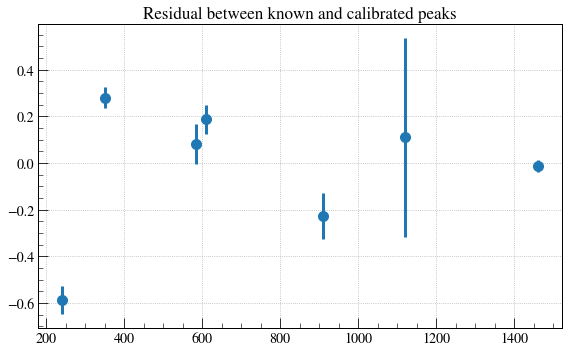

In [ ]:
fitted_peaks = pt_pars[:,0]
calibrated_peaks = np.polyval(pars, fitted_peaks)
residuals = calibrated_peaks - big_peaks_keV
#errors = 1/np.sqrt(abs(residuals))
errors = np.sqrt(pt_covs[:,0,0])
print(calibrated_peaks)
print(residuals)
print(errors)
print(big_peaks_keV)

plt.errorbar(big_peaks_keV, residuals,fmt='o',yerr=errors)

#plt.plot( big_peaks_keV, residuals, 'o')
plt.title('Residual between known and calibrated peaks')
print('pars: ', pars)
print('covs: ', covs)
result_tup = {'Known peaks(keV)':big_peaks_keV,
       'Uncalibrated peaks(ADC)':found_peaks,
       'Calibrated peaks(keV)':calibrated_peaks,
       'Residuals(keV)':residuals}
pd.DataFrame(result_tup)

[239.01273558   0.96125798]


Text(0.5, 1.0, '[$\\mu$, $\\sigma$, A]=[554.22644535   1.74835515 804.72532339]\n found peak=554.2')

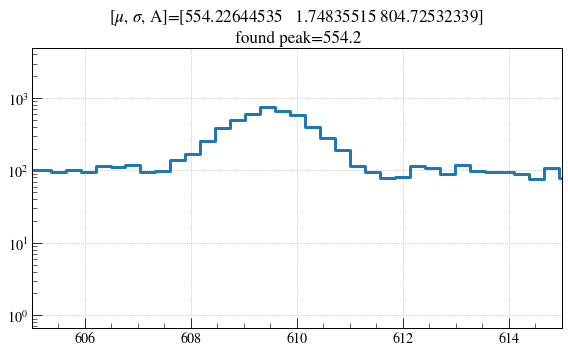

In [ ]:
pgh.plot_hist(hist_calibrated, bins_calibrated)
plt.yscale('log')

i=0
#converted_pt_pars = pt_pars
converted_pt_pars = np.polyval(pars, [pt_pars[i,0],pt_pars[i,1]])
print(converted_pt_pars)
plt.xlim(605,615)
pgu.plot_func(pgf.gauss_basic, converted_pt_pars)
plt.title('[$\mu$, $\sigma$, A]='+str(pt_pars[i])+'\n found peak='+str(found_peaks[i]))

NameError: name 'current_best_pars' is not defined

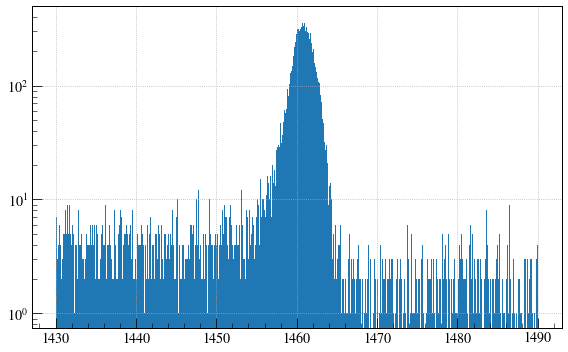

In [ ]:
def fit_gaussian_calibrated_energy_around(zooming_around, gaussian_pars, 
                                            zooming_binning_factor=0.06, 
                                            zooming_range=10, 
                                            pgh_formatted=False, 
                                            log_scale=True, 
                                            markers=True, 
                                            zooming_sigma=15):
    zooming_energy_calibrated = energy_calibrated[
        (energy_calibrated>(zooming_around-zooming_range)) & 
        (energy_calibrated<(zooming_around+zooming_range))]
    zooming_hist, zooming_bins, zooming_var = pgh.get_hist(zooming_energy_calibrated, 
                                                    bins=int(n_bins*zooming_binning_factor))

    zooming_imaxes = imaxes_calibrated[
        (bin_centers_calibrated[imaxes_calibrated]>(zooming_around-zooming_range)) & 
        (bin_centers_calibrated[imaxes_calibrated]<(zooming_around+zooming_range))]
    #print(zooming_imaxes)
    #print(hist[zooming_imaxes])

    if pgh_formatted:
        pgh.plot_hist(zooming_hist, zooming_bins, zooming_var)
        #plt.ylim(0.1,1.1*np.amax(hist))
    else:
        plt.hist(zooming_energy_calibrated, bins=int(n_bins*zooming_binning_factor))
        #print(max(zooming_energy_calibrated))
    if markers:
        plt.plot(bin_centers_calibrated[zooming_imaxes], 
                 hist_calibrated[zooming_imaxes], lw=0, marker='v')
        #plt.plot(zooming_bin_centers[zooming_imins], zooming_hist[zooming_imins], lw=0, marker='^')
    if log_scale: plt.yscale('log')
    
    
    converted_gaussian_pars = np.polyval(current_best_pars, gaussian_pars)
    mu = converted_gaussian_pars[0]
    sigma = converted_gaussian_pars[1]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    c=0
    c=max(zooming_energy_calibrated)/max(stats.norm.pdf(x, mu, sigma))
    print(max(zooming_energy_calibrated))
    print(max(stats.norm.pdf(x, mu, sigma)))
    plt.plot(x, stats.norm.pdf(x, mu, sigma)*c)
    #pgu.plot_func(pgf.gauss_basic,converted_gaussian_pars, )
    plt.title('[$\mu$, $\sigma$, A]='+str(converted_gaussian_pars))

    #plt.title('Location of extremas on hist of energy_uncalibrated (log scale)', fontsize=title_fontsize)

fit_gaussian_calibrated_energy_around(1460, pt_pars[1], 
                                        log_scale=True, markers=False, zooming_range=30)
print(calibrated_peaks)

In [ ]:
tol = 10
imax = 618
max_bin_center = bin_centers_calibrated[imax]
#print(hist_calibrated[max_bin_center])

plt.hist(energy_uncalibrated, bins=tol*2, range=(max_bin_center-tol,max_bin_center+tol))

#pgh.plot_hist(hist_calibrated[imax-tol:imax+tol], bins_calibrated[imax-tol:imax+tol+1], var_calibrated[imax-tol:imax+tol])

converted_pt_pars = np.polyval(current_best_pars, pt_pars[1])
#print(type(converted_pt_pars))
#pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(hist, bins, var, found_peaks, n_to_fit=7)
#print(pt_pars)

pgu.plot_func(pgf.gauss_basic, converted_pt_pars)
plt.title('[$\mu$, $\sigma$, A]='+str(converted_pt_pars)+'\n Calibrated peak='+str(calibrated_peaks[1]))
print(converted_pt_pars)
#plt.yscale('log')
#print(calibrated_peaks)
#plt.ylim(0.1,1.1*np.amax(hist[imax-tol:imax+tol]))

## Goodness of fit of known peaks vs found peaks

In [ ]:
'''
best_chisquare = scst.chisquare(calibrated_peaks, big_peaks_keV)[0]
best_deg = 1
best_pars, best_cov = cb.hpge_fit_E_scale(mus, mu_vars, big_peaks_keV, deg=1)

print(best_pars)

print(pars)

for i in range(1,len(big_peaks_keV)-1):
    #print('Trying deg=',i)
    pars, cov = cb.hpge_fit_E_scale(mus, mu_vars, big_peaks_keV, deg=i)
    pars, cov = cb.hpge_fit_E_cal_func(mus, mu_vars, big_peaks_keV, pars, deg=i)
    found_peaks = found_peaks[0:len(mus)]
    calibrated_peaks = np.polyval(pars, found_peaks)
    chisquare = scst.chisquare(calibrated_peaks, big_peaks_keV)[0]
    if(chisquare < best_chisquare):
        best_chisquare = chisquare
        best_deg = i
        best_pars = pars
        best_cov = cov
        

print('Uncalibrated peaks: ', found_peaks)
print('Given peaks: ', big_peaks_keV)
print('Calibrated peaks: ', calibrated_peaks)
print('\n')
print('Best deg: ', best_deg)
print('Best chisquare:', best_chisquare)
print('Best pars: ', best_pars)
print('Best covs: ', best_cov)


plt.plot(big_peaks_keV, label='given peaks')
plt.plot(calibrated_peaks, label='calibrated peaks')
plt.legend()
plt.title('corelation between given peaks and found peaks', fontsize=title_fontsize)
'''